In [33]:
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt

from serina import TestSet
import torchaudio.transforms as AT
import torchaudio
import torchvision.transforms as VT

In [34]:
SAMPLE_RATE = 44100

/Volumes/PData/AI/Conda/anaconda3/envs/serina/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


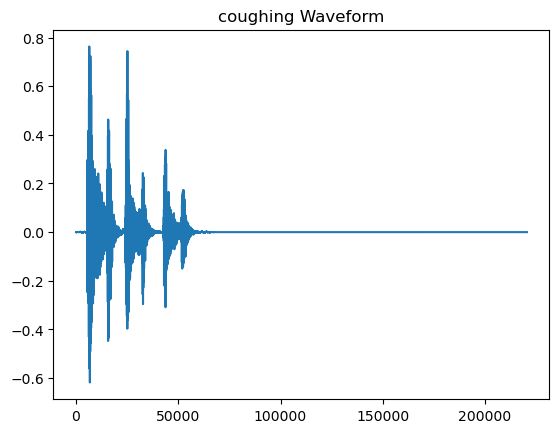

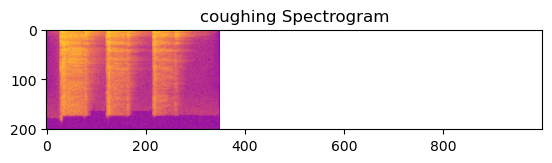

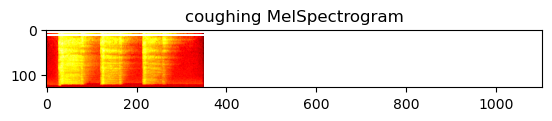

In [35]:
from serina import TrainSet, RawWaveSet

set = RawWaveSet(0, 1)
raw_tensor, _, path, category = set[500]

plt.figure()
plt.title(f"{category} Waveform")
plt.plot(raw_tensor.t().numpy())

plt.figure()
plt.title(f"{category} Spectrogram")
spec = AT.Spectrogram()(raw_tensor)
plt.imshow(spec.log2()[0, :, :1000].numpy(), cmap='plasma')

plt.figure()
plt.title(f"{category} MelSpectrogram")
spec = AT.MelSpectrogram()(raw_tensor)
plt.imshow(spec.log2()[0, :, :].numpy(), cmap='hot')

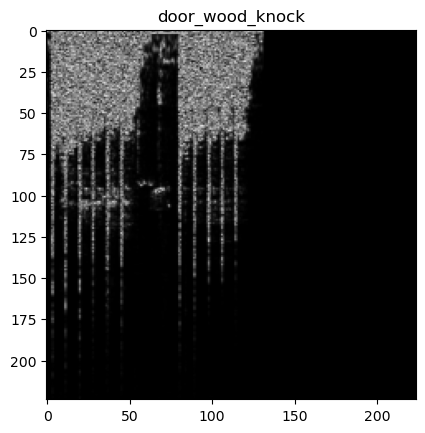

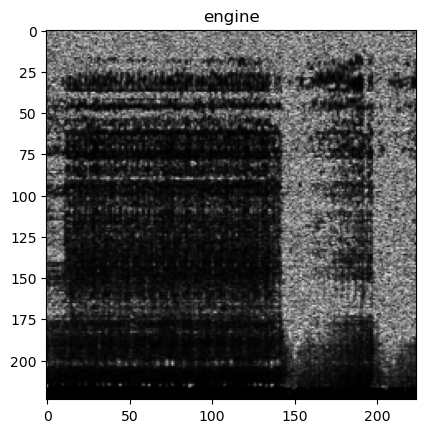

In [36]:
preprocess = VT.Compose([
    AT.MelSpectrogram(sample_rate=44100, f_max=18000, n_mels=224, n_fft=4096,
                      win_length=2205, hop_length=308),
    VT.ToPILImage(),
    VT.Lambda(lambda x: x.convert('RGB')),
    VT.Resize((224, 224)),
    VT.ToTensor(),  # 将图片转换为Tensor
    # VT.Normalize(mean=[0.485, 0.456, 0.406],  # 图像标准化
    #              std=[0.229, 0.224, 0.225]),
]
)

for i in [800, 900]:
    raw_tensor, _, path, category = set[i]
    p = VT.ToPILImage()(preprocess(raw_tensor))
    plt.figure()
    plt.title(category)
    plt.imshow(p)

In [37]:
from serina import TransformedWaveSet, build_transform, label_to_index


class PaperSet(TransformedWaveSet):
    def __init__(self, start_percent, end_percent):
        super().__init__(transform=VT.Compose([
            AT.MelSpectrogram(sample_rate=44100, f_max=18000, n_mels=224, n_fft=4096,
                              win_length=2205, hop_length=308),
            VT.ToPILImage(),
            VT.Lambda(lambda x: x.convert('RGB')),
            VT.Resize((224, 224)),
            VT.ToTensor(),  # 将图片转换为Tensor
            # VT.Normalize(mean=[0.485, 0.456, 0.406],  # 图像标准化
            #              std=[0.229, 0.224, 0.225])
        ]), start_percent=start_percent, end_percent=end_percent)
        self.cache = {}

    def __getitem__(self, item):
        if item in self.cache:
            return self.cache[item]

        tensor, sample_rate, path, category = super().__getitem__(item)

        r = tensor, label_to_index(category)
        self.cache[item] = r
        return r


train_set = PaperSet(0, 0.6)
train_loader = train_set.to_data_loader()

val_set = PaperSet(0.6, 0.8)
val_loader = val_set.to_data_loader()

In [38]:
from torch import nn, optim
from serina import create_model, get_num_classes, conf

device = conf["device"]
model = create_model(get_num_classes())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

model.to(device)
criterion.to(device)

/Volumes/PData/AI/Conda/anaconda3/envs/serina/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/PData/AI/Conda/anaconda3/envs/serina/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CrossEntropyLoss()

In [ ]:
from progress.bar import Bar
from IPython.display import clear_output, display

max_epochs = 20
for epoch in range(max_epochs):
    # clear_output(True)
    # print("Start")
    for i, (inputs, labels) in enumerate(train_loader):
        labels = labels.to(conf["device"])
        inputs = inputs.to(conf["device"])
        
        # 梯度清零
        optimizer.zero_grad()

        # 前向 + 反向 + 优化
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()
    print(f"Epoch {epoch + 1} trained, loss {loss.item()}")

    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for i, (inputs, labels) in enumerate(val_loader):
            labels = labels.to(conf["device"])
            inputs = inputs.to(conf["device"])

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # 获取每个样本的最大logit值索引作为预测结果

            val_loss += criterion(outputs, labels).item()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        _accuracy = correct / total

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch + 1} validated, loss {val_loss}, accuracy {_accuracy * 100:.2f}%")

Epoch 1 trained, loss 2.3946592807769775
Epoch 1 validated, loss 0.041982532143592835, accuracy 34.00%
Epoch 2 trained, loss 1.6287883520126343
Epoch 2 validated, loss 0.0352899032831192, accuracy 45.50%
Epoch 3 trained, loss 1.0395816564559937
Epoch 3 validated, loss 0.030655796825885772, accuracy 48.75%
Epoch 4 trained, loss 0.8187665939331055
Epoch 4 validated, loss 0.02750510424375534, accuracy 52.50%
Epoch 5 trained, loss 0.6935510635375977
Epoch 5 validated, loss 0.030711847841739654, accuracy 49.50%
Epoch 6 trained, loss 0.39807143807411194
Epoch 6 validated, loss 0.03169298350811005, accuracy 54.75%
Epoch 7 trained, loss 0.3695184290409088
Epoch 7 validated, loss 0.030358673930168154, accuracy 57.75%
Epoch 8 trained, loss 0.15610815584659576
Epoch 8 validated, loss 0.028544286787509917, accuracy 56.50%
Epoch 9 trained, loss 0.09294483065605164
Epoch 9 validated, loss 0.029348759949207305, accuracy 58.00%
Epoch 10 trained, loss 0.27073678374290466
Epoch 10 validated, loss 0.0267